In [3]:
# libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, SelectFromModel
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from utils import create_dataset_mri, cv


#CDE
#from cde.density_estimator import MixtureDensityNetwork
from tensorflow.python.keras.activations import tanh

#TF
import tensorflow as tf
import tensorflow.keras as keras

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# load the data
behavioral = pd.read_csv("data/Behavioral/AllData.csv")

# general info
shape = behavioral.shape  #2096, 7042
print(shape)

(2096, 7042)


In [5]:
list(filter(lambda x: "SWAN" in x, behavioral.columns))

['SWAN_01',
 'SWAN_02',
 'SWAN_03',
 'SWAN_04',
 'SWAN_05',
 'SWAN_06',
 'SWAN_07',
 'SWAN_08',
 'SWAN_09',
 'SWAN_10',
 'SWAN_11',
 'SWAN_12',
 'SWAN_13',
 'SWAN_14',
 'SWAN_15',
 'SWAN_16',
 'SWAN_17',
 'SWAN_18',
 'SWAN_IN_Avg',
 'SWAN_HY_Avg',
 'SWAN_Avg']

# Consider the dataset with all patients

(1146, 371)
(1047, 371)


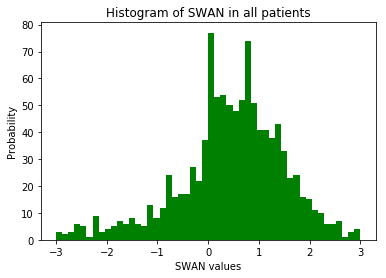

0.45022795319961795
1.0840538870603444


In [8]:
target = 'SWAN_Avg'
disease = None
#disease = 'Attention-Deficit/Hyperactivity Disorder'
category = None
#category = 'DX_01_Sub' #Irrelevant since we are dropping the columns after

# Create the dataset dropping the diagnosis columns since we are not interested in them
data = create_dataset_mri(select_disease = disease, select_category = category, SCORE = target)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]


# Plot distribution of the target variable
plt.hist(data[target], 50, density=False, facecolor='g')
plt.xlabel('SWAN values')
plt.ylabel('Probability')
plt.title('Histogram of SWAN in all patients')
plt.show()

print(np.mean(data[target]))
print(np.var(data[target]))

In [10]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'ID'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Store the dimensionality of the input
input_dim = X.shape[1]

## Define baseline

In [11]:
# Baseline: predict always the average
pred = np.full_like(np.zeros(len(y)), fill_value=np.mean(y))
mse = sum((pred - y)**2)/len(y)
print('Prediction mean: {}'.format(np.mean(y)))
print('MSE mean: {}'.format(mse))
r2 = r2_score(y_pred=(pred), y_true=y)
print('R2 mean: {}'.format(r2))

pred = np.full_like(np.zeros(len(y)), fill_value=np.median(y))
mse = sum((pred - y)**2)/len(y)
print('\nPrediction median: {}'.format(np.median(y)))
print('MSE median: {}'.format(mse))
r2 = r2_score(y_pred=pred, y_true=y)
print('R2 median: {}'.format(r2))

Prediction mean: 0.45022795319961795
MSE mean: 1.0840538870603398
R2 mean: 0.0

Prediction median: 0.5
MSE median: 1.086531143703044
R2 median: -0.002285178506593377


**Note:** the r^2 is defined as 1 minus the ratio between the MSE of the model and the MSE of the sample mean, so it does not give us any additional info but it makes the comparison with the baseline more immediate.

### Simple Linear Regression

In [12]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 1.7797535190717155
R squared: -0.656544761443168


### Linear Regression + Tree-based feature selection

In [13]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 1.2771931751747052
R squared: -0.17967690792931812


### SVR + Tree-based feature selection

In [31]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('regression', SVR())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 1.1319851999514388
R squared: -0.051594297254489746


### Random Forest

In [33]:
search_space = [1,5,10,30,60,100,200]
mses_to_plot = []
for n_trees in search_space:

    pipe = Pipeline([ ('scaling', StandardScaler()),
      ('rf', RandomForestRegressor(n_estimators=n_trees, n_jobs=4))
    ])
    (mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

    mse = np.mean(mses)
    mses_to_plot.append(mse)
    print('MSE: {}'.format(mse))
    r2 = np.mean(r2s)
    print('R squared: {}'.format(r2))

MSE: 2.0393775595622845
R squared: -0.9127386096135589
MSE: 1.266946649126635
R squared: -0.17441894696402016
MSE: 1.174582923762376
R squared: -0.0952029103872856
MSE: 1.1148086210476473
R squared: -0.030819185103058158
MSE: 1.0857915491221886
R squared: -0.005850801345270856
MSE: 1.0768620388523003
R squared: 0.0011897054662792228
MSE: 1.0744828593006543
R squared: 0.002059041231217404


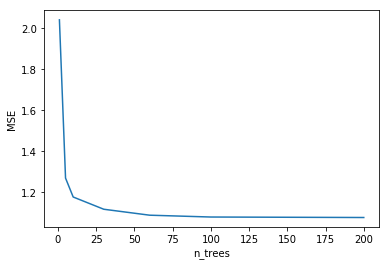

In [36]:
# Show relationship between size of the forest and error
plt.plot(search_space, mses_to_plot)
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.show()

### Neural Net

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(input_dim,)),
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(64, activation='tanh'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
def cv_for_nn(model, data, labels, n_splits = 5):
    '''
    model: must be a sklearn object with .fit and .predict methods
    data: the X matrix containing the features, can be a pd.DataFrame or a np object (array or matrix)
    labels: y, can be a pd.DataFrame or a np array
    n_splits: number of desired folds
    => returns array of mean suqared error calculated on each fold
    '''
    kf = KFold(n_splits=n_splits, shuffle=True)
    data = np.array(data).astype('float32')
    labels = np.array(labels).astype('float32')
    mses = []
    i = 1
    for train, test in kf.split(data):
        print("Split: {}".format(i), end="\r")
        X_train, X_test, y_train, y_test = data[train], data[test], labels[train], labels[test]
        
        reset_weights(model)
        
        model.fit(x=X_train, y=y_train, verbose=0, epochs=1000)
        mse = model.evaluate(x=X_test,  y=y_test, verbose=1)[0]
        
        pred = model.predict(x=X_test)
        
        mse2 = sum((pred.flatten()-y_test)**2)/len(y_test)
        
        print('MSE: {}'.format(mse))
        mses.append(mse)
        i = i+1
    return mses

res = cv_for_nn(model=model, data=X_scaled, labels=y, n_splits=5)
np.mean(res)

210/210 [==============================] - 0s 125us/sample - loss: 1.2678 - acc: 0.0143
MSE: 1.2677655066762652
210/210 [==============================] - 0s 30us/sample - loss: 1.5205 - acc: 0.0238
MSE: 1.520510348819551
209/209 [==============================] - 0s 40us/sample - loss: 1.3719 - acc: 0.0096
MSE: 1.371868743850854
209/209 [==============================] - 0s 26us/sample - loss: 1.4873 - acc: 0.0239
MSE: 1.4872614481802762
209/209 [==============================] - 0s 34us/sample - loss: 1.4483 - acc: 0.0622
MSE: 1.4483287807857022


1.4191469656625295

### Conclusions
There seems to be almost no relationship between the MRI data and the results to the SWAN test, if all patients are considered regardless the diagnosis.

# Consider only patients with ADHD

(463, 371)
(450, 371)


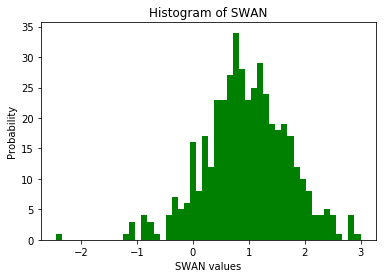

0.9497527133333333
0.5616656733379334


In [59]:
target = 'SWAN_Avg'
#disease = None
disease = 'Attention-Deficit/Hyperactivity Disorder'
#category = None
category = 'DX_01_Sub' #Irrelevant since we are dropping the columns after

# Create the dataset dropping the diagnosis columns since we are not interested in them
data = create_dataset_mri(select_disease = disease, select_category = category, SCORE = target)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]


plt.hist(data[target], 50, density=False, facecolor='g')
plt.xlabel('SWAN values')
plt.ylabel('Probability')
plt.title('Histogram of SWAN')
plt.show()


print(np.mean(data[target]))
print(np.var(data[target]))

In [60]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'ID'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Store the dimensionality of the input
input_dim = X.shape[1]

## Define baseline

In [61]:
# Baseline: predict always the average
pred = np.full_like(np.zeros(len(y)), fill_value=np.mean(y))
mse = sum((pred - y)**2)/len(y)
print('Prediction mean: {}'.format(np.mean(y)))
print('MSE mean: {}'.format(mse))
r2 = r2_score(y_pred=(pred), y_true=y)
print('R2 mean: {}'.format(r2))

pred = np.full_like(np.zeros(len(y)), fill_value=np.median(y))
mse = sum((pred - y)**2)/len(y)
print('\nPrediction median: {}'.format(np.median(y)))
print('MSE median: {}'.format(mse))
r2 = r2_score(y_pred=pred, y_true=y)
print('R2 median: {}'.format(r2))

Prediction mean: 0.9497527133333333
MSE mean: 0.5616656733379337
R2 mean: 0.0

Prediction median: 0.9444440000000001
MSE median: 0.5616938557751889
R2 median: -5.017653489147733e-05


**Note:** the r^2 is defined as 1 minus the ratio between the MSE of the model and the MSE of the sample mean, so it does not give us any additional info but it makes the comparison with the baseline more immediate.

### Simple Linear Regression

In [62]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 11.031219412343672
R squared: -20.37889279054704


### Linear Regression + Tree-based feature selection

In [63]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 0.8655701785184675
R squared: -0.5808504762732254


### SVR + Tree-based feature selection

In [64]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('regression', SVR())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 0.595665980920034
R squared: -0.09996718449866449


### Random Forest

In [65]:
search_space = [1,5,10,30,60,100,200]
mses_to_plot = []
for n_trees in search_space:

    pipe = Pipeline([ ('scaling', StandardScaler()),
      ('rf', RandomForestRegressor(n_estimators=n_trees, n_jobs=4))
    ])
    (mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

    mse = np.mean(mses)
    mses_to_plot.append(mse)
    print('MSE: {}'.format(mse))
    r2 = np.mean(r2s)
    print('R squared: {}'.format(r2))

MSE: 1.0910478338673795
R squared: -1.0489623354603956
MSE: 0.711120547019463
R squared: -0.2876046668681903
MSE: 0.6289759309848435
R squared: -0.1410978810268372
MSE: 0.5957055376599696
R squared: -0.09228977221403009
MSE: 0.593379478147861
R squared: -0.07565376859461881
MSE: 0.5709022044703025
R squared: -0.026389471699302613
MSE: 0.5732081588890594
R squared: -0.03797904032004623


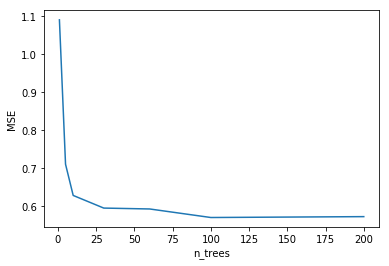

In [66]:
# Show relationship between size of the forest and error
plt.plot(search_space, mses_to_plot)
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.show()

### Conclusions
Even if we consider the subset of patients who were diagnosed ADHD, there still seems to be almost no relationship between the MRI data and the results to the SWAN test.